In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    Flatten,
    Dense,
    Dropout,
    Input,
)
import pickle 
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import shap
from tqdm import tqdm

Consruct emotion model, download and load weights (Emotion.py in Deepface)

In [5]:
input_dim_ = 64
num_classes = 2
label_names = ['Not Confused', 'Confused']

In [6]:
# load pickle file
files = ['../data_features_labels/Train_crop.pkl', '../data_features_labels/Test_crop.pkl', '../data_features_labels/Validation_crop.pkl']
# files = ['Eastern_Asian_Dataset.pkl']
x_train_list = []
y_train_list = [] 
for file in files:
    with open(file, 'rb') as f:
        features, labels = pickle.load(f)
    
    for pic, label in zip(features, labels):
        # plt.imshow(img_gray, cmap='binary_r')
        x_train_list.append(pic)
        y_train_list.append(label)
X_train = np.array(x_train_list).reshape(-1, input_dim_, input_dim_, 1)
#one-hot encode target column
Y_train = to_categorical(np.array(y_train_list))

In [7]:
seeds = np.arange(2024, 2034)
for seed in tqdm(seeds):
    x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=seed)
    model = Sequential()
    model.add(Input(shape=(64, 64, 1)))
    # 1st convolution layer
    model.add(Conv2D(64, (5, 5), activation="relu", input_shape=(input_dim_, input_dim_, 1)))
    # model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))
    
    # 2nd convolution layer
    # model.add(Conv2D(64, (3, 3), activation="relu"))
    # model.add(Conv2D(64, (3, 3), activation="relu"))
    # model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # 3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation="relu"))
    # model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    model.add(Flatten())
    
    # fully connected neural networks
    # model.add(Dense(1024, activation="relu"))
    # model.add(Dropout(0.2))
    # model.add(Dense(1024, activation="relu"))
    # model.add(Dropout(0.2))
    
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.load_weights(f'../models/DAiSEE_confusion_weights_final_{seed}.h5')
    background_num = 300
    np.random.seed(int(seed-1))
    desired_label = 1
    background = x_train[np.random.choice(x_train.shape[0], background_num, replace=False)]
    test_images = x_test
    e = shap.DeepExplainer(model, background)
    shap_values = e.shap_values(test_images, check_additivity=False)
    shap_vals = [shap_values[:, :, :, :, i] for i in range(shap_values.shape[-1])]
    with open(f'../data_shap_values/SHAP_values_DAiSEE_final_{seed}.pkl', 'wb') as f:
        pickle.dump(shap_vals, f)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/alexanderhsu/Documents/GitHub/ICSE_2025/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-02 16:44:18.577068: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-11-02 16:44:18.577104: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-11-02 16:44:18.577108: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-11-02 16:44:18.577125: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-02 16:44:18.577137: I tensorf

<AxesSubplot: xlabel='y', ylabel='count'>

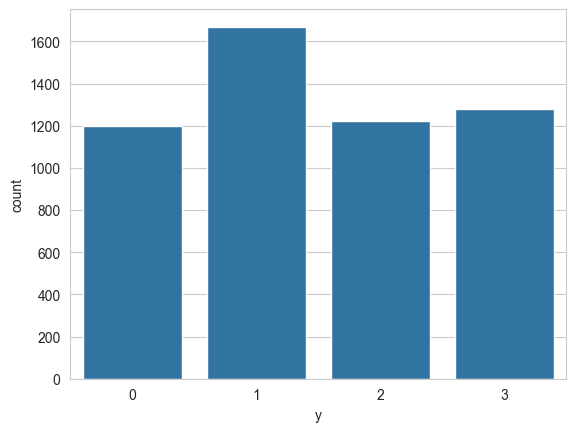

In [44]:
df = pd.DataFrame({'y': y_test_list})
sns.countplot(data=df, x='y')

<AxesSubplot: xlabel='y', ylabel='count'>

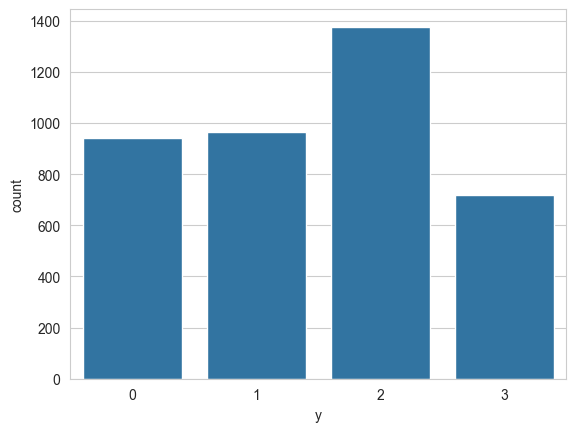

In [45]:
df = pd.DataFrame({'y': y_valid_list})
sns.countplot(data=df, x='y')

In [46]:
np.array(y_train_list).shape

(15255,)

In [73]:
from tensorflow.keras.utils import to_categorical
#one-hot encode target column
Y_train = to_categorical(np.array(y_train_list))
Y_test = to_categorical(np.array(y_test_list))
Y_validation = to_categorical(np.array(y_valid_list))
Y_train[200]

array([0., 1., 0., 0.], dtype=float32)

In [76]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((12204, 128, 128, 1), (3051, 128, 128, 1))

In [81]:
model.fit(x_train, y_train, epochs=30)

Epoch 1/30


2024-05-19 21:02:59.502562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 55s 143ms/step - loss: 5.2598 - accuracy: 0.5629
Epoch 2/30
382/382 [==============================] - 51s 134ms/step - loss: 0.6590 - accuracy: 0.7373
Epoch 3/30
382/382 [==============================] - 54s 140ms/step - loss: 0.5048 - accuracy: 0.8017
Epoch 4/30
 31/382 [=>............................] - ETA: 56s - loss: 0.3475 - accuracy: 0.8609

KeyboardInterrupt: 

In [80]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 124, 124, 64)      1664      
                                                                 
 conv2d_15 (Conv2D)          (None, 122, 122, 32)      18464     
                                                                 
 flatten_4 (Flatten)         (None, 476288)            0         
                                                                 
 dense_9 (Dense)             (None, 4)                 1905156   
                                                                 
Total params: 1,925,284
Trainable params: 1,925,284
Non-trainable params: 0
_________________________________________________________________


In [82]:
prediction_proba = model.predict(x_test)
y_predict = prediction_proba.argmax(axis=1)

 2/96 [..............................] - ETA: 7s 

2024-05-19 21:05:49.043001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 2s 24ms/step


In [83]:
y_predict.shape

(3051,)

In [84]:
y_true = y_test.argmax(axis=1)

In [85]:
# y_true = np.array(y_test_list)

In [86]:
# confusion matrix
conf_mat = confusion_matrix(y_true, y_predict, normalize='true')

<AxesSubplot: >

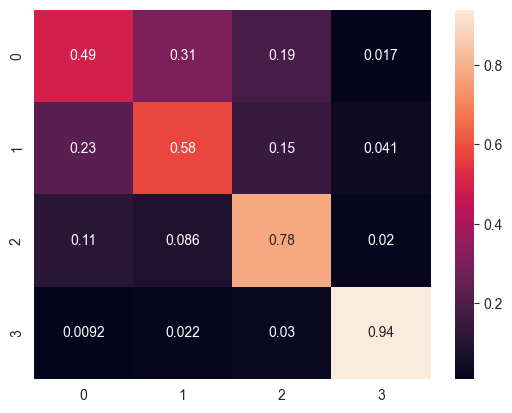

In [87]:
sns.heatmap(conf_mat, annot=True)